a)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.cosmology as cosmo
import astropy.coordinates as coord
import emcee

In [2]:
my_columns = ['Redshift','Distance','Error']
data = pd.read_csv('SN.data',names=my_columns,skiprows=1)

In [3]:
data

,Redshift,Distance,Error
0,0.336886,1480.919735,73.014139
1,0.186857,750.610735,37.321367
2,0.442316,2088.225990,100.775470
3,0.388877,1789.298150,86.443520
4,0.181246,768.578074,36.080277
...,...,...,...
495,0.140422,554.107761,27.264601
496,0.919220,5040.818899,249.077286
497,0.429994,1984.276772,97.424628
498,0.239588,1014.942769,49.325590


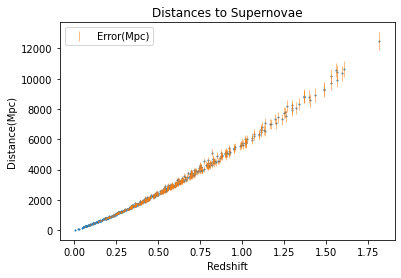

In [4]:
plt.plot(data['Redshift'],data['Distance'],'o',markersize=1)
plt.errorbar(x=data['Redshift'],y=data['Distance'],yerr=data['Error'],linestyle='None',label='Error(Mpc)',linewidth=0.5)
plt.title('Distances to Supernovae')
plt.xlabel('Redshift')
plt.ylabel('Distance(Mpc)')
plt.legend()

b)

In [109]:
#Likelihood Function
def lnlike(theta,redshift,SN_distance,distance_err):
    Om,Ode,H0=theta
    my_cosmo = cosmo.LambdaCDM(H0=H0, Om0=Om, Ode0=Ode)
    model_distance = my_cosmo.luminosity_distance(redshift).values.value
    return -np.sum(((SN_distance-model_distance)/distance_err)**2)

#prior
def prior(theta):
    Om,Ode,H0 = theta
    if (0 < Om <10 and 0< Ode <10 and 0< H0<100):
        return 1
    return -np.inf

#posterior
def posterior(theta,redshift,SN_distance,distance_err):
    lp= prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,redshift,SN_distance,distance_err)

#the data
redshift = data['Redshift']
SN_distance = data['Distance']
distance_err = data['Error']

np.random.seed(1273649)

#the starting guesses
pos = [0.3,0.1,75]+np.random.rand(50, 3) #50 walkers, 3 dimensions

#number of runs
nruns=5000
Nburn=1000

#number of walkers and number of dimensions are the same as the starting guesses
nwalkers,ndim = pos.shape

#set up and run sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(redshift,SN_distance,distance_err))
sampler.run_mcmc(pos, nruns, progress=True)

100%|██████████| 5000/5000 [06:20<00:00, 13.12it/s]


In [118]:
#the mcmc samples
flat_samples = sampler.get_chain(discard=100, thin=5, flat=True)

#the best fit values for the parameters are the medians of their samples
Om = np.median(flat_samples[:,0])
Ode = np.median(flat_samples[:,1])
H0= np.median(flat_samples[:,2])

In [116]:
print('The cosmological model that best fits the data is one with Ω_m = %.3f'%Om,', Ω_Λ = %.3f'%Ode,', and H_0 = %.3f'%H0)

The cosmological model that best fits the data is one with Ω_m = 0.215 , Ω_Λ = 0.636 , and H_0 = 81.945


c)

In [120]:
flat_samples.shape

(49000, 3)

In [141]:
#best fit chi^2
best_cosmo = cosmo.LambdaCDM(H0=H0,Om0=Om,Ode0=Ode)
best_dists = best_cosmo.luminosity_distance(data['Redshift']).values.value
chi2 = np.sum(((data['Distance']-best_dists)/data['Error'])**2)
print('For the derived cosmological parameters, χ^2 = %.3f'%chi2,' and there were 49000 samples.')

For the derived cosmological parameters, χ^2 = 179.576  and there were 49000 samples.


d)

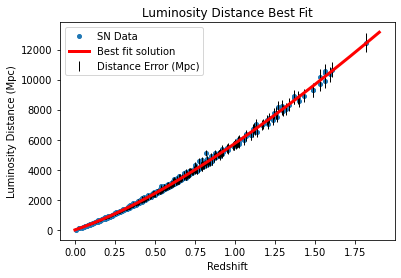

In [160]:
z=data['Redshift']
my_z = np.linspace(0,1.9,1000)
dists = data['Distance']
best_fit = best_cosmo.luminosity_distance(my_z).value
err = data['Error']
plt.plot(z,dists,'o',markersize=4,label='SN Data')
plt.errorbar(x=z,y=dists,yerr=err,linestyle='None',linewidth=1,label='Distance Error (Mpc)',color='black')
plt.plot(my_z,best_fit,label='Best fit solution',linewidth=3,color='r')
plt.xlabel('Redshift')
plt.ylabel('Luminosity Distance (Mpc)')
plt.title('Luminosity Distance Best Fit')
plt.legend()

e)

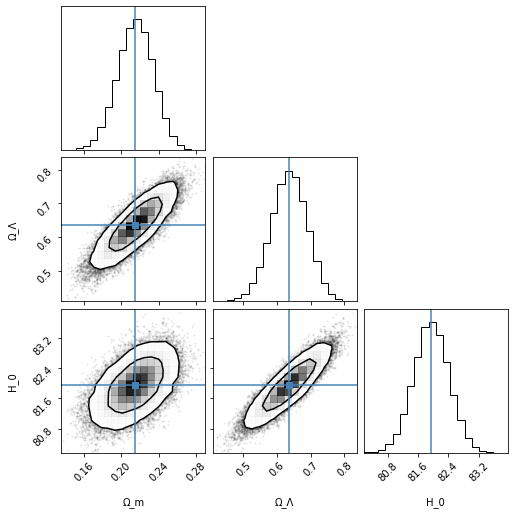

In [168]:
import corner

my_labels = ['Ω_m','Ω_Λ','H_0']
my_truths = [Om,Ode,H0]

fig = corner.corner(
    flat_samples,labels=my_labels,truths=my_truths,levels=[0.68,0.95]
);